# FIREARM-RELATED DEATHS STATS - WORLD

### causes, rates, trends in gun ownership and freedom index per country

This notebook is dedicated to transforming and exploring the data on gun ownership and firearm-related deaths that I have extracted from ... One particular point of interest for me is to see whether there is evidence in the data that deaths caused by conforontations with police are correlated with overall firearm-related deaths and gun ownership per country. I was motivated by news of daily police shootings in the US that end fatally because of a simple wrong assumption: that the person pursued had a gun in their hand or was reaching for one (insert news links here).

Not accounting for the high rates of implicit bias that affect officers' judgements in these situations, it got me thinking: "because of the US's perspective on guns, the probability that the other person has a gun is always high. So wouldn't the rate of gun ownership in a country directly contribute to police fatalities if police are to often assume a gun is involved and set out to defend themselves instead of de-escalate and protect?". So why not test this assumption with some data?

It is no surprise by now that the US is a serious outlier regarding gun ownership, gun laws (or the lack thereof) and overall firearm-related violence and deaths compared to other developed countries. So I decided to look into the data for the rest of the world first to see if any overall trends can be estabilished. The three main questions I'm looking to answer with this exploratory analysis are:
1. Is there evidence for correlation between the firearm and police death rates with firearm ownership rates?
2. Are there trends in the death rates by firearm and police with respect to how developed a country is? 
3. Which countries are the rates for the US closest to?

As a proxy for how developed a country is, I'll be using the freedom index values, in particular personal freedom. I have chosen personal freedom over human or economic freedom, mostly because the justification for the high rate of firearm ownership in the US comes from the Second Amendement, which is closely related to individual liberty and prevention of "an over-reaching federal government".

## Data

- **IHME-GBD data set** - the data set is generated using the GBD Results tool, (citation: Global Burden of Disease Collaborative Network. Global Burden of Disease Study 2019 (GBD 2019) Results. Seattle, United States: Institute for Health Metrics and Evaluation (IHME), 2020. Available from http://ghdx.healthdata.org/gbd-results-tool.). Contains firearm-related deaths per country, per year for years 2013-2019, grouped by age group, sex and cause.
- **global gun ownership** - downloaded from Wikipedia https://en.wikipedia.org/wiki/Gun_ownership / the Small Arms Survey for 2017
- **freedom index** - downloaded from Kaggle https://www.kaggle.com/gsutters/the-human-freedom-index?select=hfi_cc_2020.csv (most recent year 2017)

*The above data can be found as .csv files in the raw_data/ folder*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

## Data wrangling

### Transform the IHME-GBD data

In [2]:
df_ihme = pd.read_csv('raw_data/IHME-GBD_2019_DATA.csv')
df_ihme.head()

,measure,location,sex,age,cause,metric,year,val,upper,lower
0,Deaths,Peru,Male,All Ages,Self-harm by firearm,Number,2013,37.707543,52.778423,17.774173
1,Deaths,Peru,Female,All Ages,Self-harm by firearm,Number,2013,5.738864,7.510162,4.284653
2,Deaths,Peru,Male,All Ages,Self-harm by firearm,Percent,2013,0.000489,0.000685,0.000239
3,Deaths,Peru,Female,All Ages,Self-harm by firearm,Percent,2013,0.000087,0.000110,0.000068
4,Deaths,Peru,Male,All Ages,Self-harm by firearm,Rate,2013,0.244087,0.341644,0.115055


We can immediately see that the above table is not very helpful for exploratory analysis as features like age, sex, cause and metric are all listed as separate rows with corresponding unique values. For my particular questions and assumptions, I do not yet care about stats on different sexes and age groups involve, but I do care about the country, year and specific cause. So let's transform the data set so that it is more convenient to filter on these features.

In [3]:
def transform_ihme_data(df_in, detailed=False):
    '''
    A function that transforms the IHME data rows into columns corresponding to the different causes and metrics.
    
    INPUT
    -----
    df_in - pandas IHME dataframe with causes, sex, age and metrics stored in rows
    detailed - if true, creates columns separated by age and sex, if false sums over age groups and sexes
    
    OUTPUT
    ------
    df_out - transformed pandas dataframe, such that causes and metrics are stored in separate columns
    '''
    
    # identify the unique countries and years
    countries = df_in['location'].unique()
    years = df_in['year'].unique()
    # generate new table with two columns based on the cartesian product of countries and years
    df_out = pd.DataFrame.from_records(list(itertools.product(countries, years)), columns =['country', 'year'])
    
    # sort by country and year to preserve the same order as all the columns that are going to be added
    df_out = df_out.sort_values(['country', 'year']).reset_index().drop('index', axis=1)
    
    # generate all other necessary columns and initialize them with nans
    # the dictionary keys defined here are used to short-name the columns
    cause_keys = {'self-firearm': 'Self-harm by firearm', 
              'self-other': 'Self-harm by other specified means',
               'violence-firearm': 'Physical violence by firearm',
               'violence-sharp': 'Physical violence by sharp object',
               'violence-other': 'Physical violence by other means',
               'police': 'Executions and police conflict', 
               'unintentional': 'Unintentional firearm injuries',
               'terrorism': 'Conflict and terrorism'}
    
    metric_keys = {'number': 'Number', 'perc': 'Percent', 'rate': 'Rate'}
    
    for metric in metric_keys.keys():
        for cause in cause_keys.keys():
            
            if detailed:
                # groups by sex and age as well instead of marginalizing over them
                age_keys = {'50-90': '50 to 74 years', 
                            '10-24': '10 to 24', 
                            '25-29': '25 to 49', 
                            '75+': '75 plus', 
                            '0-9': '0 to 9'}
    
                sex_keys = {'m': 'Male', 'f': 'Female'}
        
                for age in age_keys.keys():
                    df_filter = (df_in['cause']==cause_keys[cause]) & (df_in['age']==age_keys[age]) & (df_in['metric']==metric_keys[metric])
                    df_out['%s_%s_%s' % (cause, age, metric)] = df_in[df_filter].sort_values(['location', 'year']).groupby(['location', 'year']).sum().reset_index()['val']
                for sex in sex_keys.keys():
                    df_filter = (df_in['cause']==cause_keys[cause]) & (df_in['sex']==sex_keys[sex]) & (df_in['metric']==metric_keys[metric])
                    df_out['%s_%s_%s' % (cause, sex, metric)] = df_in[df_filter].sort_values(['location', 'year']).groupby(['location', 'year']).sum().reset_index()['val']
            
            else:
                df_filter = (df_in['cause']==cause_keys[cause]) & (df_in['metric']==metric_keys[metric])
                df_out['%s_%s' % (cause, metric)] = df_in[df_filter].sort_values(['location', 'year']).groupby(['location', 'year']).sum().reset_index()['val']

    return df_out

In [4]:
df_ihme_tf = transform_ihme_data(df_ihme, detailed=False)
df_ihme_tf.head()

,country,year,self-firearm_number,self-other_number,violence-firearm_number,violence-sharp_number,violence-other_number,police_number,unintentional_number,terrorism_number,...,unintentional_perc,terrorism_perc,self-firearm_rate,self-other_rate,violence-firearm_rate,violence-sharp_rate,violence-other_rate,police_rate,unintentional_rate,terrorism_rate
0,Afghanistan,2013,172.974098,2692.400955,780.357729,789.842519,7186.837875,35.783851,174.612584,23657.634008,...,0.005810,0.812965,5.171030,70.103084,12.431410,13.161331,127.710444,0.995728,3.768440,450.235768
1,Afghanistan,2014,174.339785,2714.164837,777.951659,786.142510,7276.272981,32.041359,171.908139,36015.927162,...,0.005214,1.134994,5.100228,69.097155,12.079067,12.811437,126.052777,0.909710,3.627186,664.745408
2,Afghanistan,2015,177.355686,2756.860693,1462.323749,1013.961017,7601.975505,34.508585,171.706981,47333.601352,...,0.004824,1.387440,5.051065,68.388525,22.595110,16.129857,128.096516,0.936164,3.536791,852.489168
3,Afghanistan,2016,181.668481,2827.823862,1296.711643,971.596797,7796.768567,45.267057,173.452215,56102.000000,...,0.004619,1.568276,5.012669,67.851349,19.298544,14.995783,127.080381,1.095435,3.461555,978.750544
4,Afghanistan,2017,187.018829,2908.444544,1361.209242,1007.288316,8012.530302,886.920278,174.948906,38712.783426,...,0.005012,1.183084,4.986791,67.304260,19.603129,15.050625,126.116602,14.570797,3.371430,652.517637


Perfect! The new dataframe now has each column labeled by the cause and metric keys and we can easily filter and explore them!

Before moving forward, let's also isolate only the data for 2017 since that's the only year we have gun ownership rates for and the latest year we have freedom index data for.

In [5]:
df_ihme_2017 = df_ihme_tf[df_ihme_tf['year']==2017].reset_index().drop(columns=['index'])
df_ihme_2017.head()

,country,year,self-firearm_number,self-other_number,violence-firearm_number,violence-sharp_number,violence-other_number,police_number,unintentional_number,terrorism_number,...,unintentional_perc,terrorism_perc,self-firearm_rate,self-other_rate,violence-firearm_rate,violence-sharp_rate,violence-other_rate,police_rate,unintentional_rate,terrorism_rate
0,Afghanistan,2017,187.018829,2908.444544,1361.209242,1007.288316,8012.530302,886.920278,174.948906,38712.783426,...,0.005012,1.183084,4.986791,67.304260,19.603129,15.050625,126.116602,14.570797,3.371430,652.517637
1,Albania,2017,54.461033,257.351040,83.660177,17.156939,19.251091,0.651914,7.686850,0.000000,...,0.009259,0.000000,11.493582,56.505412,15.728801,3.466970,4.486062,0.145138,1.590110,0.000000
2,Algeria,2017,138.020033,2764.741830,276.608554,121.113692,551.078085,71.005593,99.633571,214.000000,...,0.007000,0.016572,2.623289,42.464929,3.226813,1.549309,6.858399,1.058640,1.606191,3.269986
3,American Samoa,2017,0.645391,7.194841,0.413170,0.738425,5.182826,0.012070,0.175987,0.000000,...,0.005744,0.000000,6.441145,89.248259,5.419256,6.981019,55.884719,0.185149,2.399068,0.000000
4,Andorra,2017,0.964629,14.660086,0.151278,0.188857,0.572290,0.023679,0.035469,0.000000,...,0.002066,0.000000,8.776468,112.181799,0.912225,1.195915,3.745676,0.162725,0.297844,0.000000


### Adding features

#### country codes

When adding more features to the above data set, we need to match the dataframes by the country name. However, different data sources may have different versions of a country's name. For example, "Bahamas", "Bahamas, The", "The Bahamas", "The Commonwealth of The Bahamas", are all valid names for the same country. So it's useful to instead assign a unique code to each country in the separate data sets and use the country code instead of the country name for combining them.

To do this we'll use the CDS Open Geo Dataset (https://coronadatasource.org/open-data/cds-world-countries-open-geo-dataset/) that offers a very convenient table that translates country names (various versions included) to country codes.

In [6]:
geodata = pd.read_csv('raw_data/TranslateCountryNamesToCodes.csv')
geodata.head()

,Forms of country names,Country Name (usual),2char country code,3char country code,Type of match,Possible mismatch
0,Afghanistan,Afghanistan,AF,AFG,Country name,NaN
1,Akrotiri and Dhekelia,United Kingdom,GB,GBR,Country name,NaN
2,?land,Aland Islands,AX,ALA,Country name,NaN
3,Aland Islands,Aland Islands,AX,ALA,Country name,NaN
4,?land Islands,Aland Islands,AX,ALA,Country name,NaN


In [7]:
def add_country_codes(df, geodata, country_column = 'country'):
    '''
    Assigns a country code from the CDS Open Geo Dataset to dataframe with country names.
    
    INPUT
    -----
    df - pandas dataframe to be modified
    geodata - geodata dataset as pandas dataframe with columns for '3char country code' and 'Forms of country names'
    country_column - exact name of the country column in df
    
    OUTPUT
    ------
    df_codes - dataframe with added country_code columns
    
    '''
    df_codes = df.copy()
    country_codes = np.empty(df_codes.shape[0], dtype="U25")
    country_codes[:] = 'nan'
#     df_codes['country_code'] = np.nan
    for i,country in enumerate(df_codes[country_column].values):
        try:
            country_codes[i] = geodata['3char country code'][geodata['Forms of country names']==country].values[0]
        except:
            # if the full name can't be found, try the first word only
            try:
                country_first = country.split(' ')[0]
                country_codes[i] = geodata['3char country code'][geodata['Forms of country names']==country_first].values[0]
            except:
                try:
                    country_first = country.split(' ')[-1]
                    country_codes[i] = geodata['3char country code'][geodata['Forms of country names']==country_first].values[0]
                except:
                    try:
                        country_first = country.split(',')[0]
                        country_codes[i] = geodata['3char country code'][geodata['Forms of country names']==country_first].values[0]
                    except:
                        # if the first word didn't work, print the name for manual lookup in geodata
                        print('{} NO MATCH - Manually find and assign code for {}'.format(i,country))

    
    return country_codes

In [8]:
country_codes = add_country_codes(df_ihme_2017, geodata, country_column='country')

47 NO MATCH - Manually find and assign code for Côte d'Ivoire


There is one country that the function couldn't match, so we need to try to locate it manually (by dropping special characters in this case)

In [9]:
geodata[geodata['Forms of country names']=="Cote d'Ivoire"]

,Forms of country names,Country Name (usual),2char country code,3char country code,Type of match,Possible mismatch
73,Cote d'Ivoire,Cote d'Ivoire,CI,CIV,Country name,NaN


In [10]:
country_codes[47] = 'CIV'
df_ihme_2017['country_code'] = country_codes

Let's finally check if there are any remaining nans in the country codes column:

In [11]:
df_ihme_2017['country_code'].isnull().any()

False

In [12]:
df_ihme_2017.head()

,country,year,self-firearm_number,self-other_number,violence-firearm_number,violence-sharp_number,violence-other_number,police_number,unintentional_number,terrorism_number,...,terrorism_perc,self-firearm_rate,self-other_rate,violence-firearm_rate,violence-sharp_rate,violence-other_rate,police_rate,unintentional_rate,terrorism_rate,country_code
0,Afghanistan,2017,187.018829,2908.444544,1361.209242,1007.288316,8012.530302,886.920278,174.948906,38712.783426,...,1.183084,4.986791,67.304260,19.603129,15.050625,126.116602,14.570797,3.371430,652.517637,AFG
1,Albania,2017,54.461033,257.351040,83.660177,17.156939,19.251091,0.651914,7.686850,0.000000,...,0.000000,11.493582,56.505412,15.728801,3.466970,4.486062,0.145138,1.590110,0.000000,ALB
2,Algeria,2017,138.020033,2764.741830,276.608554,121.113692,551.078085,71.005593,99.633571,214.000000,...,0.016572,2.623289,42.464929,3.226813,1.549309,6.858399,1.058640,1.606191,3.269986,DZA
3,American Samoa,2017,0.645391,7.194841,0.413170,0.738425,5.182826,0.012070,0.175987,0.000000,...,0.000000,6.441145,89.248259,5.419256,6.981019,55.884719,0.185149,2.399068,0.000000,ASM
4,Andorra,2017,0.964629,14.660086,0.151278,0.188857,0.572290,0.023679,0.035469,0.000000,...,0.000000,8.776468,112.181799,0.912225,1.195915,3.745676,0.162725,0.297844,0.000000,AND


Let's also drop any potential duplicate country codes:

In [13]:
df_ihme_2017=df_ihme_2017.drop_duplicates(subset=['country_code'], keep='first')

In [14]:
df_ihme_2017[df_ihme_2017['country_code']=='USA']

,country,year,self-firearm_number,self-other_number,violence-firearm_number,violence-sharp_number,violence-other_number,police_number,unintentional_number,terrorism_number,...,terrorism_perc,self-firearm_rate,self-other_rate,violence-firearm_rate,violence-sharp_rate,violence-other_rate,police_rate,unintentional_rate,terrorism_rate,country_code
195,United States of America,2017,47905.661309,45574.573706,27927.860861,4088.267502,5645.058289,2497.98459,1395.6189,33.010839,...,0.000389,92.928467,73.02352,42.702148,6.365803,11.017095,3.615327,2.552773,0.063905,USA


Awesome, our initial data is ready for more features from other sources!

#### gun ownership

In [15]:
df_gun_ownership = pd.read_csv('raw_data/gun_ownership_2017.csv')
df_gun_ownership.head()

,Country,Firearms,Population,Firearms/100
0,Afghanistan,4270000.0,34169000.0,12.50
1,Albania,350000.0,2911000.0,12.00
2,Algeria,877000.0,41064000.0,2.10
3,American Samoa,400.0,56000.0,0.70
4,Andorra,10000.0,69000.0,14.10


To combine the gun ownership data with the existing IHME dataframe, we need to add a country codes column as well. 

In [16]:
gun_country_codes = add_country_codes(df_gun_ownership, geodata, country_column='Country')

31 NO MATCH - Manually find and assign code for Cabo Verde (Cape Verde)
47 NO MATCH - Manually find and assign code for C�te d'Ivoire (Ivory Coast)
112 NO MATCH - Manually find and assign code for Lao, People's Democratic Republic
156 NO MATCH - Manually find and assign code for Palestinian Territories
165 NO MATCH - Manually find and assign code for Puntland
173 NO MATCH - Manually find and assign code for Saint Martin (France)
177 NO MATCH - Manually find and assign code for S�o Tom� and Principe
185 NO MATCH - Manually find and assign code for Sint Maarten (Netherlands)
190 NO MATCH - Manually find and assign code for Somaliland
224 NO MATCH - Manually find and assign code for Virgin Islands (U.K.)
225 NO MATCH - Manually find and assign code for Virgin Islands (U.S.)


There are more countries with no corresponding codes here and not all of it is due to special characters or unconventional names. 

For example, the "Palestinian territories" typically refers to territories occupied by Israel since 1967. However, since there is no country by the name of Palestine in the gun ownership data, we'll assume that Palestinian Territories refers to the State of Palestine. 

In addition, Puntland and Somaliland are both self-declared sovereign states in Somalia and both carry the country code of Somalia. We can assign both the country code for Somalia, but this may pose problems when combining the data sets expecting unique country codes. So we can instead sum up the data from both rows and create a new row for Somalia with the corresponding unique country code.

In [17]:
geodata[(geodata['Forms of country names'] == "Cape Verde")
        | (geodata['Forms of country names'] == "Cote d'Ivoire")
        | (geodata['Forms of country names'] == "Laos")
        | (geodata['Forms of country names'] == "Palestine")
        | (geodata['Forms of country names'] == "Saint Martin")
        | (geodata['Forms of country names'] == "Sao Tome and Principe")
        | (geodata['Forms of country names'] == "Sint Maarten")
        | (geodata['Forms of country names'] == "British Virgin Islands")
        | (geodata['Forms of country names'] == "U.S. Virgin Islands")
        | (geodata['Forms of country names'] == "Somalia")
][['Forms of country names', '3char country code']]

,Forms of country names,3char country code
43,British Virgin Islands,VGB
54,Cape Verde,CPV
73,Cote d'Ivoire,CIV
174,Laos,LAO
235,Palestine,PSE
273,Saint Martin,MAF
281,Sao Tome and Principe,STP
290,Sint Maarten,SXM
295,Somalia,SOM
772,U.S. Virgin Islands,VIR


In [18]:
# 31 NO MATCH - Manually find and assign code for Cabo Verde (Cape Verde)
# 47 NO MATCH - Manually find and assign code for C�te d'Ivoire (Ivory Coast)
# 112 NO MATCH - Manually find and assign code for Lao, People's Democratic Republic
# 156 NO MATCH - Manually find and assign code for Palestinian Territories
# 165 NO MATCH - Manually find and assign code for Puntland
# 173 NO MATCH - Manually find and assign code for Saint Martin (France)
# 177 NO MATCH - Manually find and assign code for S�o Tom� and Principe
# 185 NO MATCH - Manually find and assign code for Sint Maarten (Netherlands)
# 190 NO MATCH - Manually find and assign code for Somaliland
# 224 NO MATCH - Manually find and assign code for Virgin Islands (U.K.)
# 225 NO MATCH - Manually find and assign code for Virgin Islands (U.S.)
missing_indices = [31,47,112,156,173,177,185,224,225]
missing_codes = ['CPV', 'CIV', 'LAO', 'PSE', 'MAF', 'STP', 'SXM', 'VGB', 'VIR']
gun_country_codes[missing_indices] = missing_codes

In [19]:
df_gun_ownership['country_code'] = gun_country_codes

In [20]:
df_gun_ownership[df_gun_ownership['country_code']=='USA']

,Country,Firearms,Population,Firearms/100,country_code
218,United States of America,393347000.0,326474000.0,120.50,USA


In [21]:
df_gun_ownership.head()

,Country,Firearms,Population,Firearms/100,country_code
0,Afghanistan,4270000.0,34169000.0,12.50,AFG
1,Albania,350000.0,2911000.0,12.00,ALB
2,Algeria,877000.0,41064000.0,2.10,DZA
3,American Samoa,400.0,56000.0,0.70,ASM
4,Andorra,10000.0,69000.0,14.10,AND


We took care of all the 'easy' country codes, now we just need to clean up the data on the two Somalian territoritories (indices: 165 (Puntland) and 190 (Somaliland)):

In [22]:
somalia_data = {'Country': 'Somalia', 
                'Firearms': df_gun_ownership['Firearms'][165]+df_gun_ownership['Firearms'][190],
                'Population': df_gun_ownership['Population'][165]+df_gun_ownership['Population'][190],
                'Firearms/100': float(df_gun_ownership['Firearms/100'][165])+float(df_gun_ownership['Firearms/100'][190]),
                'country_code': 'SOM'}

In [23]:
df_gun_ownership = df_gun_ownership.append(somalia_data, ignore_index=True).drop([165,190], axis=0)

In [24]:
df_gun_ownership = df_gun_ownership.drop_duplicates(subset=['country_code'], keep='first')

In [25]:
df_gun_ownership

,Country,Firearms,Population,Firearms/100,country_code
0,Afghanistan,4270000.0,34169000.0,12.50,AFG
1,Albania,350000.0,2911000.0,12.00,ALB
2,Algeria,877000.0,41064000.0,2.10,DZA
3,American Samoa,400.0,56000.0,0.70,ASM
4,Andorra,10000.0,69000.0,14.10,AND
...,...,...,...,...,...
224,Virgin Islands (U.K.),300.0,31000.0,0.80,VGB
225,Virgin Islands (U.S.),18000.0,107000.0,16.60,VIR
226,Yemen,14859000.0,28120000.0,52.80,YEM
227,Zambia,158000.0,17238000.0,0.90,ZMB


Finally, let's combine this dataframe with the IHME data. At this point, we can already start makingdecisions on what data to keep and what to discard. Since the main goal is to study firearm related deaths, there is no use keeping data on gun ownership for countries for which we don't have data on firearm deaths.

In [26]:
df_ihme_guns = df_ihme_2017.merge(df_gun_ownership, on='country_code', how='left').drop(columns=['Country', 'year'])

In [27]:
df_ihme_guns['Firearms/100'][df_ihme_guns['Firearms/100'] =='<0.1'] = 0.1
df_ihme_guns['firearm-ownership_rate'] = df_ihme_guns['Firearms/100'].astype('float64')*1000

<ipython-input-27-dbb33b60b396>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ihme_guns['Firearms/100'][df_ihme_guns['Firearms/100'] =='<0.1'] = 0.1


#### freedom indices

Finally, let's add the freedom indices. The Kaggle data set is extensive and offers a lot of different indices that relate to the political, religious, justice and economic freedom. Looking into all of these different features is out of the scope of this overview, so we'll only keep the overall freedom index and the personal and economical freedom indices.

In [28]:
df_fi = pd.read_csv('raw_data/hfi_cc_2020.csv')[['ISO_code', 'countries', 'year',
                                                'hf_score', 'hf_rank',
                                               'pf_score', 'pf_rank',
                                               'ef_score', 'ef_rank']]
df_fi_2017 = df_fi[df_fi['year']==2017].reset_index().rename(columns={'ISO_code': 'country_code'}).set_index('country_code')

In [29]:
df_fi_2017

,index,countries,year,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank
country_code,,,,,,,,,
ALB,1,Albania,2017,7.78,44.0,7.86,47.0,7.70,36.0
DZA,12,Algeria,2017,5.03,154.0,5.08,151.0,4.98,157.0
AGO,23,Angola,2017,5.39,148.0,5.91,126.0,4.86,159.0
ARG,34,Argentina,2017,7.16,64.0,8.34,39.0,5.98,133.0
ARM,45,Armenia,2017,7.60,50.0,7.34,68.0,7.85,21.0
...,...,...,...,...,...,...,...,...,...
VEN,1728,"Venezuela, RB",2017,3.85,161.0,4.97,153.0,2.72,162.0
VNM,1739,Vietnam,2017,6.28,117.0,6.40,109.0,6.16,125.0
YEM,1750,"Yemen, Rep.",2017,4.53,158.0,2.94,161.0,6.11,127.0


In [30]:
df_ihme_guns_fi = df_ihme_guns.merge(df_fi_2017, how='left', on='country_code').drop(columns=['Firearms/100','countries','year','index'])
df_ihme_guns_fi

,country,self-firearm_number,self-other_number,violence-firearm_number,violence-sharp_number,violence-other_number,police_number,unintentional_number,terrorism_number,self-firearm_perc,...,country_code,Firearms,Population,firearm-ownership_rate,hf_score,hf_rank,pf_score,pf_rank,ef_score,ef_rank
0,Afghanistan,187.018829,2908.444544,1361.209242,1007.288316,8012.530302,886.920278,174.948906,38712.783426,0.005630,...,AFG,4270000.0,34169000.0,12500.0,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,54.461033,257.351040,83.660177,17.156939,19.251091,0.651914,7.686850,0.000000,0.073718,...,ALB,350000.0,2911000.0,12000.0,7.78,44.0,7.86,47.0,7.70,36.0
2,Algeria,138.020033,2764.741830,276.608554,121.113692,551.078085,71.005593,99.633571,214.000000,0.009413,...,DZA,877000.0,41064000.0,2100.0,5.03,154.0,5.08,151.0,4.98,157.0
3,American Samoa,0.645391,7.194841,0.413170,0.738425,5.182826,0.012070,0.175987,0.000000,0.017443,...,ASM,400.0,56000.0,700.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Andorra,0.964629,14.660086,0.151278,0.188857,0.572290,0.023679,0.035469,0.000000,0.022900,...,AND,10000.0,69000.0,14100.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,Venezuela (Bolivarian Republic of),1442.036947,3122.225361,19736.056612,1252.412411,1935.551110,650.429998,1269.260991,56.000000,0.075986,...,VEN,5895000.0,31926000.0,18500.0,3.85,161.0,4.97,153.0,2.72,162.0
199,Viet Nam,288.258425,15706.480093,256.277650,1512.262012,848.555703,69.463285,486.944141,15.852478,0.004136,...,VNM,1562000.0,95415000.0,1600.0,6.28,117.0,6.40,109.0,6.16,125.0
200,Yemen,164.443766,2693.566833,910.400659,350.459376,986.706135,30.771942,238.252868,33618.455238,0.006966,...,YEM,14859000.0,28120000.0,52800.0,4.53,158.0,2.94,161.0,6.11,127.0
201,Zambia,176.295155,2506.696056,1015.752371,781.515581,1263.955969,6.578970,225.469442,2.000000,0.009599,...,ZMB,158000.0,17238000.0,900.0,6.70,97.0,6.19,115.0,7.20,66.0


Voila! We have our dataset! Let's save it before moving onto the exploratory analysis and dealing with missing values.

In [31]:
df_ihme_guns_fi = df_ihme_guns_fi.drop_duplicates(subset=['country_code'], keep='first')

In [32]:
df_ihme_guns_fi.to_csv('project_data/ihme_guns_fi.csv')

## Data exploration

histograms, correlation matrices, outliers, significant features

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
df = pd.read_csv('project_data/ihme_guns_fi.csv')

In [42]:
df = df[['country','country_code',
         'violence-firearm_rate', 'violence-sharp_rate', 'violence-other_rate', 
         'police_rate', 'firearm-ownership_rate',
        'hf_score', 'ef_score', 'pf_score']]

In [43]:
df.describe()

,violence-firearm_rate,violence-sharp_rate,violence-other_rate,police_rate,firearm-ownership_rate,hf_score,ef_score,pf_score
count,203.000000,203.000000,203.000000,203.000000,198.000000,159.000000,159.000000,159.000000
mean,31.355114,22.563057,28.110657,2.304289,9644.090909,6.921761,6.845094,6.994025
std,58.530514,30.412157,27.116416,10.471460,12661.895750,1.116043,0.951160,1.452226
min,0.208987,0.767546,0.980850,0.104855,0.000000,3.710000,2.720000,2.360000
25%,2.706905,3.972720,7.644640,0.134968,2000.000000,6.220000,6.240000,6.025000
50%,9.005631,10.735665,18.071526,0.226502,5550.000000,6.890000,6.890000,6.990000
75%,32.172835,31.401874,42.107295,0.763273,13200.000000,7.840000,7.600000,8.035000
max,401.817746,261.832809,155.072580,134.257780,120500.000000,8.860000,8.700000,9.420000


We see that we're missing the freedom scores for about 40 countries. In this step, we'll explore differences between high-freedom vs low-freedom score countries. So let's further cleanup the data set and drop the rows with missing freedom indices.

In [44]:
df_fi = df.dropna()

This also dropped the two rows with missing firearms rates, but that's okay! Since the main goal here is to compare the USA to the rest of the world, let us first get a feel for what the data values are for USA (this will enable us primarily to highlight it on the plots):

In [45]:
df[df['country_code']=='USA']

,country,country_code,violence-firearm_rate,violence-sharp_rate,violence-other_rate,police_rate,firearm-ownership_rate,hf_score,ef_score,pf_score
194,United States of America,USA,42.702148,6.365803,11.017095,3.615327,120500.0,8.55,8.34,8.75


In [62]:
# df_fi['firearm_frac'] = 100*df_fi['firearm-ownership_rate']/df_fi['firearm-ownership_rate'].sum()
# df_fi['violence-firearm_frac'] = 100*df_fi['violence-firearm_rate']/df_fi['violence-firearm_rate'].sum()
# df_fi['police_frac'] = 100*df_fi['police_rate']/df_fi['police_rate'].sum()

Let's plot all the available datadepicting the gun ownership rates, gun violence and police violence rates per country. We'll set the x-scale as log to better visualize the different rates, as some can vary by orders of magnitude compared to the rest. We'll sort the countries by descending gun ownership. If there is any evidence of gun ownership rates affecting the gun violence and police violence rates, we would expect those to descrese accordingly.

In [60]:
df_fi = df_fi.sort_values(by='firearm-ownership_rate', ascending=False)

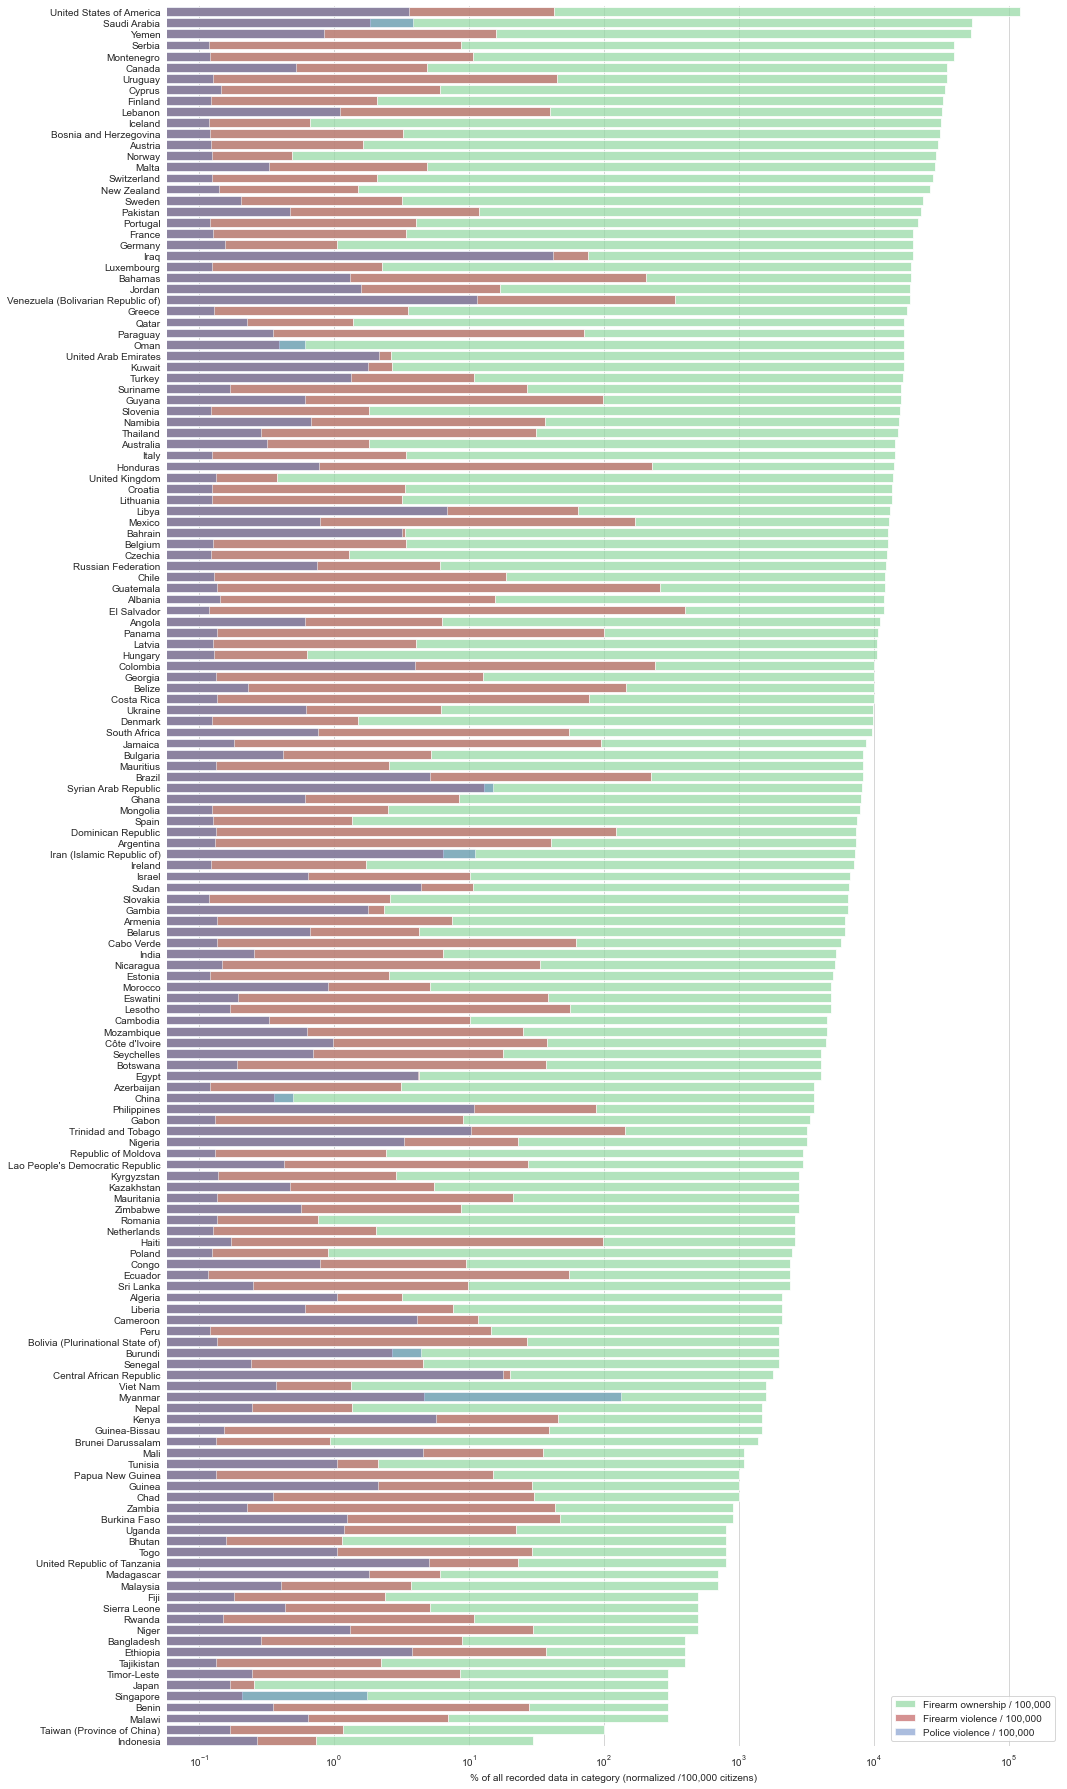

In [64]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(16,32))
sns.set_color_codes("pastel")
sns.barplot(x='firearm-ownership_rate', y='country_code', data=df_fi,
            label="Firearm ownership / 100,000", color="g", alpha=0.75,
            dodge=0.5)

sns.set_color_codes("muted")
sns.barplot(x="violence-firearm_rate", y="country", data=df_fi,
            label="Firearm violence / 100,000", color="r", alpha=0.75,
           dodge=True)

# sns.set_color_codes("muted")
sns.barplot(x="police_rate", y="country", data=df_fi,
            label="Police violence / 100,000", color="b", alpha=0.5,
           dodge=True)
# Add a legend and informative axis label
ax.legend(ncol=1, loc="lower right", frameon=True)
ax.set(ylabel="",
       xlabel="% of all recorded data in category (normalized /100,000 citizens)")
sns.despine(left=True, bottom=True)

ax.set_xscale('log')
# ax.set_xlim((3e-3,35))
# fig, ax = plt.subplots(figsize=(8,40))
# df_fi.sort_values(by='firearm_frac', ascending=False).set_index('country_code')[["firearm_frac", "violence-firearm_frac", "police_frac"]].plot.barh(ax=ax)

The first thing to note is that there is no significant trend between gun ownership and violence. A significant portion of high-ranked countries in terms of gun-ownership demonstrate orders of magnitude lower rates compared to, for example, the US, which has the highest number of guns per capita, or other lower-ranked countries.

As such, the bar plot is not helpful for drawing any conclusions. So let's instead plot the firearm violence and police violence rates as a function of the personal freedom index, and embed the firearm ownership rates in the sizes of the scatter points. We'll also highlight the regions around values for USA to determine which countries it is most similar to in regards to these two features.

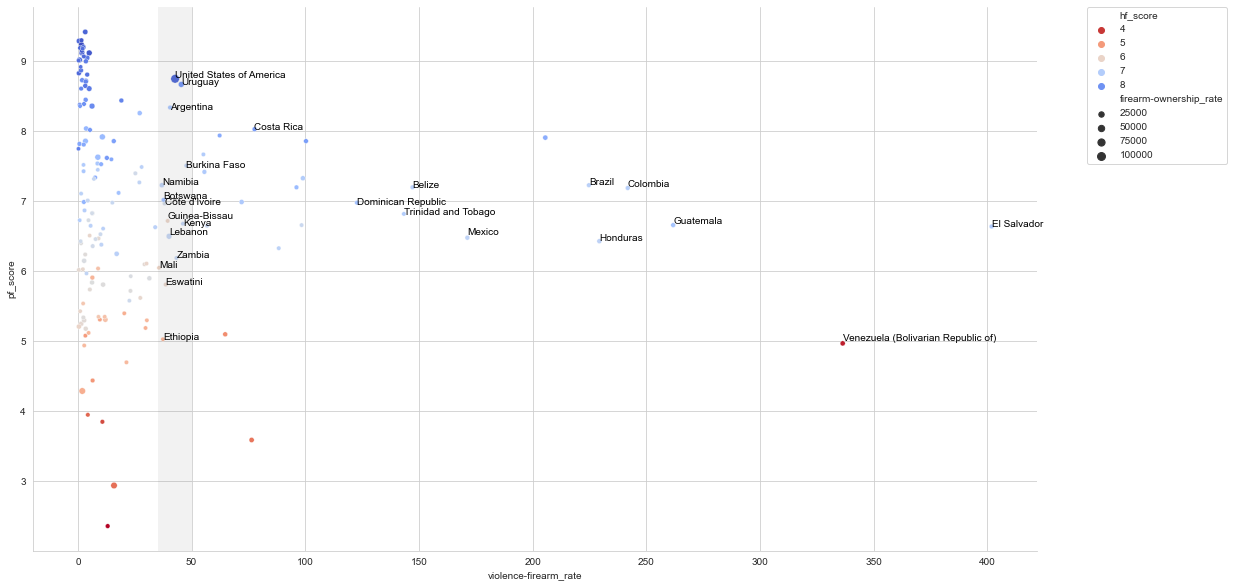

In [65]:
plt.figure(figsize=(18,10))
np.random.seed(42)
sns.scatterplot(data=df_fi, x='violence-firearm_rate', y='pf_score', 
                hue='hf_score', palette='coolwarm_r',
                size='firearm-ownership_rate')
for country_code in df_fi['country_code'][ ((df_fi['violence-firearm_rate'] > 100) &
                                            (df_fi['pf_score'] < 7.5))
                                         | ((df_fi['violence-firearm_rate'] > 40) & 
                                            (df_fi['pf_score'] > 8))
                                         | ((df_fi['violence-firearm_rate'] < 50) &
                                            (df_fi['violence-firearm_rate'] > 35))]:
    plt.text(x=df_fi['violence-firearm_rate'][df_fi.country_code==country_code].values[0]+0.0001,
             y=df_fi['pf_score'][df_fi.country_code==country_code].values[0]+0.001+np.random.normal(0,0.02),
             s=df_fi['country'][df_fi.country_code==country_code].values[0],
             fontdict=dict(color='black',size=10),
         )
sns.despine(right=True, top=True)
plt.axvspan(35, 50, color='grey', alpha=0.1, lw=0)
# plt.xlim(0,0.15)
# plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

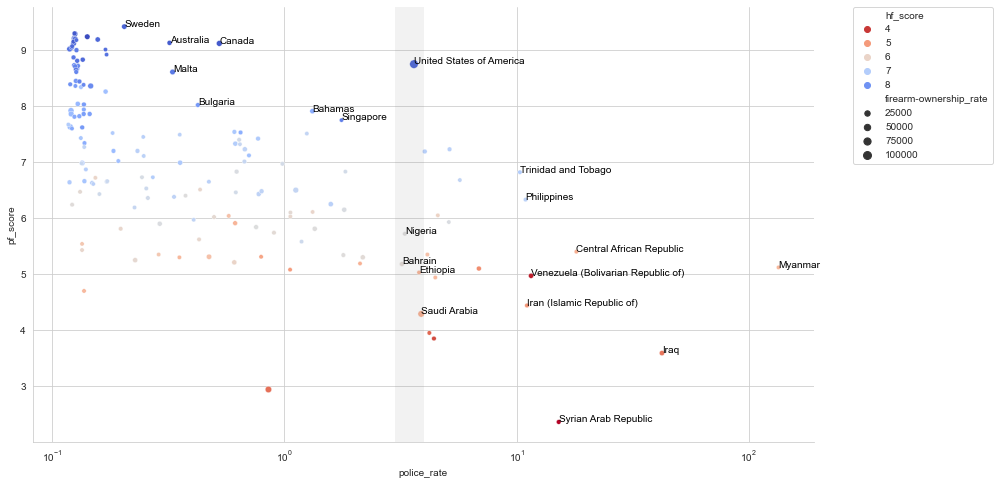

In [66]:
fig, ax = plt.subplots(figsize=(14,8))
sns.scatterplot(data=df_fi, x='police_rate', y='pf_score', 
                hue='hf_score', size='firearm-ownership_rate', palette='coolwarm_r', ax=ax)
np.random.seed(41)
mask =  ((((df_fi['police_rate'] > 3) & (df_fi['police_rate'] < 4) & (df_fi['pf_score'] < 7.7))
          | (df_fi['police_rate'] > 10)
         | ((df_fi['police_rate'] > 0.2) & (df_fi['pf_score'] > 7.7))))

for country_code in df_fi['country_code'][mask]:
    ax.text(x=df_fi['police_rate'][mask][df_fi.country_code==country_code].values[0]+0.001,
             y=df_fi['pf_score'][mask][df_fi.country_code==country_code].values[0]+0.0001,
             s=df_fi['country'][mask][df_fi.country_code==country_code].values[0],
             fontdict=dict(color='black',size=10),
         )
    
# ax.set_xlim((-0.01,0.125))
sns.despine(right=True, top=True)
ax.axvspan(3, 4, color='grey', alpha=0.1, lw=0)
ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Ignoring USA, we can observe three distinct groups in both of these features, that fall roughly within the ranges: pfi>8, 6<pfi<8 and pfi<6. Let's split the data according to this *percieved* grouping into countries with high, medium and low PFI and plot the heatmap of feature correlations to see if provides any valuable insight.

In [67]:
df_high_pfi = df_fi[df_fi['pf_score'] > 8]
df_med_pfi = df_fi[(6 <= df_fi['pf_score']) & (df_fi['pf_score'] <= 8)]
df_low_pfi = df_fi[df_fi['pf_score'] < 6]

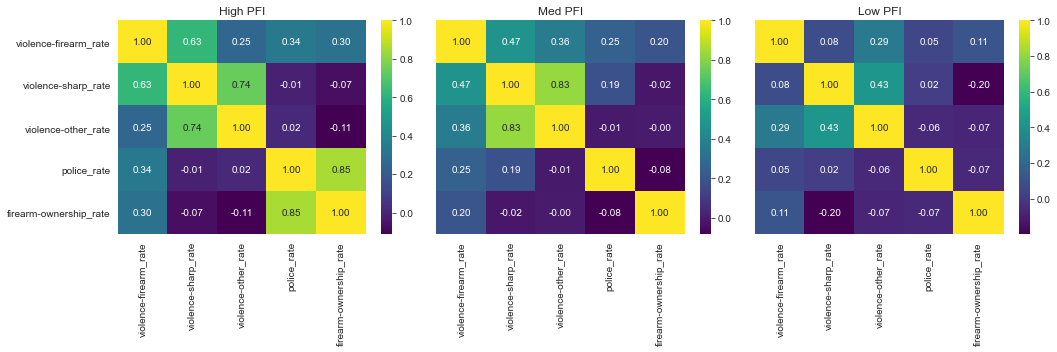

In [68]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

sns.heatmap(df_high_pfi[['violence-firearm_rate', 'violence-sharp_rate', 'violence-other_rate', 
         'police_rate', 'firearm-ownership_rate']].corr(), annot=True, fmt=".2f", cmap='viridis', ax=axes[0])
sns.heatmap(df_med_pfi[['violence-firearm_rate', 'violence-sharp_rate', 'violence-other_rate', 
         'police_rate', 'firearm-ownership_rate']].corr(), annot=True, fmt=".2f", cmap='viridis', ax=axes[1])
sns.heatmap(df_low_pfi[['violence-firearm_rate', 'violence-sharp_rate', 'violence-other_rate', 
         'police_rate', 'firearm-ownership_rate']].corr(), annot=True, fmt=".2f", cmap='viridis', ax=axes[2])
axes[1].set_yticks([])
axes[2].set_yticks([])
axes[0].set_title('High PFI')
axes[1].set_title('Med PFI')
axes[2].set_title('Low PFI')
plt.tight_layout()
plt.show()

Understandably so, most of these groups show high to moderate correlation between firearm and other types of violence, as well as some indication (but not strong) of correlation between firearm ownership and police/firearm violence.

However, it seems that the correlation of police violence and firearm ownership rate for the high PFI countries is unusually high, so let's take a more detailed look into what's going on with a correlation plot for that group:

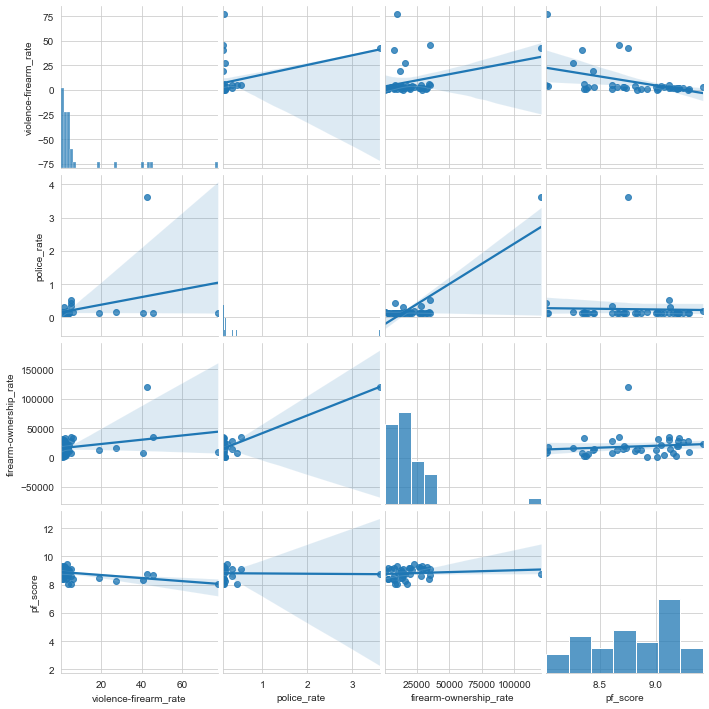

In [69]:
sns.pairplot(df_high_pfi[['violence-firearm_rate', 'police_rate', 'firearm-ownership_rate', 'pf_score']], kind="reg")
plt.show()

We immediately notice that there is one strong outlier in both the firearm ownership and police violence rates. And we already know for the scatter plots that the point corresponds to the US, so let's remove it and replot the correlation heatmap to see the resulting coefficients.

In [70]:
df_high_pfi_nousa = df_high_pfi.drop(df_high_pfi[df_high_pfi['country_code']=='USA'].index, axis=0)

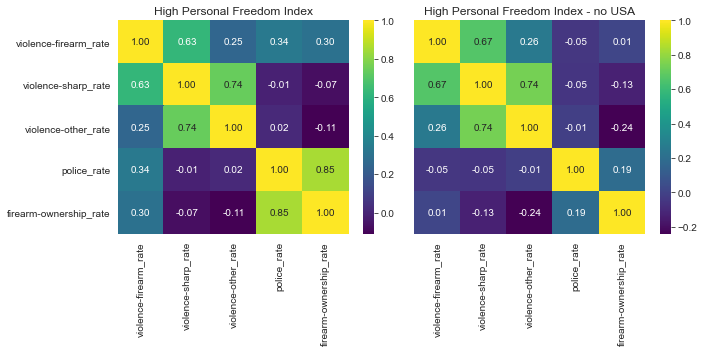

In [71]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

sns.heatmap(df_high_pfi[['violence-firearm_rate', 'violence-sharp_rate', 'violence-other_rate', 
         'police_rate', 'firearm-ownership_rate']].corr(), annot=True, fmt=".2f", cmap='viridis', ax=axes[0])
sns.heatmap(df_high_pfi_nousa[['violence-firearm_rate', 'violence-sharp_rate', 'violence-other_rate', 
         'police_rate', 'firearm-ownership_rate']].corr(), annot=True, fmt=".2f", cmap='viridis', ax=axes[1])
axes[1].set_yticks([])
axes[0].set_title('High Personal Freedom Index')
axes[1].set_title('High Personal Freedom Index - no USA')
plt.tight_layout()
plt.show()

Oops! I think we found the culprit. Not only does removing the US lower the correlation between police violence and firearm ownership, it also lowers the correlation between firearm violence and firearm ownership. What this simply means is that we cannot use other PFI countries (even after excluding the US) to model the police/firearm violence rates as a function of firearm ownership.

Here are the final conclusions from this exploratory analysis of the world data:
- There are no clear correlations between firearm ownership, firearm-caused deaths and police-caused deaths on a global level. This is understandable because a lot of these incidents are driven by the laws, politics, economy and stability within a country and these differ greatly on a global scale.
- Firearm-caused deaths show the widest range in medium-PFI countries (6 < PFI < 8), while police-caused deaths are highest for low-PFI (PFI < 6) countries. This makes sense if we take into account access to firearms and political instabilities in both of these groups.
- USA is a clear outlier in all of these categories within the high PFI group. Its firarm-caused death rates are closer to the mid-PFI countries (with much lower firearm ownership rates), while police-caused death rates fall on the boundary of the values spanned by mid-PFI and low-PFI countries.

Because the US is such a significant outlier, it is not feasible to use the world as a model for the causes and rates of firearm and police violence observed in the US. Instead, we need a model for the US alone only, for which we'll use data from each state to determine the potential existence of trends that can be useful as the basis of a linear regression model.